# Coding your own RNN

Using this pre-filled notebook, we will code our own RNN for sentence classification. For now, we'll keep using IMDB, as the goal of this part is to understand how an RNN works.

Unlike our previous lab, we will also learn the embedding layer. Which means we need to deal with vocabulary by ourselves.

In [1]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple, Any
from collections import Counter, OrderedDict
from matplotlib import pyplot as plt

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

## Dataset
We load the dataset and split the training set in a stratified train/validation set.

In [2]:
    dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (/home/adrien/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached split indices for dataset at /home/adrien/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-5f37fd0866e4f89f.arrow and /home/adrien/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

## Vocabulary (1 point)

**\[1 point\]** Build your own vocabulary. The [example provided in torchtext documentation](https://pytorch.org/text/stable/vocab.html#id1) might be of help.
* Don't forge to setup the `min_freq` parameter to not include unfrequent noise.
* You will need a tokenizer. Reuse the `basic_english` one from the our previous lab.
* For an RNN we need two special tokens: `<unk>`, for unknown words, and `<pad>` for padding.

In [3]:
tokenizer = get_tokenizer("basic_english", language="en")
counter = Counter([word for row in train_df["text"] for word in tokenizer(row)])
# counter = Counter([word for row in train_df["text"] for word in row.split()])
sorted_items = sorted(counter.items(), key=lambda item: item[1], reverse=True)
ordered = OrderedDict(sorted_items)
vocabulary = vocab(ordered, min_freq=5, specials=["<unk>", "<pad>"])
vocabulary.set_default_index(vocabulary["<unk>"])
len(vocabulary)

26973

## Vectorize and batch the input (3 points)

As seen in class, our model should take one-hot encoded vectors corresponding to the each token vocabulary id. However, computing a vector x matrix multiplication for every input is unnecessarily costly. Multiplying a one-hot vector with a matrix is the equivalent of taking one row of the matrix. In pyTorch, we provide ids for each token which will be used as input to an `nn.Embedding` layer. The id is simply the row in the embedding matrix.

**\[1 point\]** Fill the `vectorize_text` function returning a 1D torch tensor of `torch.long` for each input text.

In [4]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    return torch.tensor([vocabulary[token] for token in tokenizer(text)], dtype=torch.long)

In [5]:
text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

Check the function is working correctly, especially it should return the right special id for unknown words.

In [6]:
text_pipeline("Some text I am thinking about... ragafqfa")

tensor([  56, 3160,   13,  244,  526,   50,    3,    3,    3,    0])

In [7]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

To speed up the training process, we turn the inputs into batches, as we did last time. For batches to work, every line must have the same lengths. Last time, it was implicit as only a vector (the average of all embeddings) was provided. This time, every line has the length of a different review.

To go around this problem, we use padding. So every line within a batch is padded to the length of its longest element.

* **\[1 point\]** Fill the data generator function.


In [8]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
        :param batch_size: given batch size
        :param X: Tensor of data
        :param y: List of labels
        :param pad_id: The vectorized padding token
    """
    X, y = shuffle(X, y)
    for i in range(0, len(X), batch_size):
        batch_X = X[i : i + batch_size]
        batch_y = y[i : i + batch_size]
        max_len = max([len(x) for x in batch_X])
        batch_X = torch.stack(
            [torch.nn.functional.pad(x, (max_len - len(x), 0), value=pad_id) for x in batch_X]
        )
        yield batch_X, torch.tensor(batch_y, dtype=torch.long)

In [9]:
train_gen = lambda: data_generator(X_train, y_train, vocabulary["<pad>"])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary["<pad>"])
test_gen = lambda: data_generator(X_test, y_test, vocabulary["<pad>"])

* **\[1 point\]** On which side should you pad and why?

Le modèle traite nos vecteurs de gauche à droite. Si le padding est au début de la séquence, le modèle passe ses premières étapes sur les éléments de padding moins significatifs. En revanche, si le padding est à la fin, le modèle traitera d'abord les parties significatives de la séquence.

## Classifier (3 points)

**\[3 points\]** Code your own RNN. Fill the `RNN` class correctly. Remember an RNN has 3 matrices and an embedding layer (see course slide 61).
* The embedding layer turns a one-hot vectors into dense vectors.
* The first matrix (W) connects the embedding to the hidden layer.
  * `embedding_size -> hidden_size`
* The second matrix (U) connect the previous hidden layer to the current one.
  * `hidden_size -> hidden_size`
* These to vectors are added and go through an activation function (e.g. $h_t = tanh(Wx_i+Uh_{t-1})$).
* The last matrix (V) connects the hidden layer to the hidden layer to the output.
  * `hidden_size -> 1`
* Donc forget to add an `init_hidden` function which initialize the first hidden layer to 0.

In [10]:
class RNN(nn.Module):
    def __init__(
        self,
        vocabulary_size: int,
        embedding_size: int,
        hidden_size: int,
        output_size: int=1,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.W = nn.Linear(embedding_size, hidden_size)
        self.U = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, output_size)
        self.activation = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def init_hidden(self, batch_size: int) -> torch.Tensor:
        return torch.zeros(batch_size, self.U.in_features)

    def forward(self, x: torch.Tensor, hidden: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.embedding(x)
        x = self.W(x)
        new_hidden = self.activation(x + self.U(hidden))
        x = self.V(new_hidden)
        return x, new_hidden

## Training (2 points)

Training is a bit different than usual. We will need to sequentially (but in "batch parallel") go through an input, keeping track of the hidden layer, and use the last output as prediction.

**\[2 point\]** Code the training loop.
* Note that for each batch, you need to loop through the whole input and use the output of the last token as input to your criterion.
* Keep the best model evaluated on the validation set.
* Plot the training and validation losses.
* Training will take some time (~30 min on a T4 GPU). Make sure your results appear in the notebook.

In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [12]:
n_embedding = 32
n_hidden = 64
model = RNN(len(vocabulary.get_itos()), n_embedding, n_hidden).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
n_epochs = 3

In [13]:
def train(
    model: nn.Module,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_gen: Generator[Tuple[torch.Tensor, torch.Tensor], None, None],
    valid_gen: Generator[Tuple[torch.Tensor, torch.Tensor], None, None],
    n_epochs: int,
    device: str,
):
    """
    Train a model.
    Args:
        model: a PyTorch Module.
        criterion: a PyTorch loss function.
        optimizer: a PyTorch optimizer.
        train_gen: a generator returning training batches.
        valid_gen: a generator returning validation batches.
        n_epochs: the number of epochs.
        device: the device to run the training on.
    Returns:
        A tuple of train and validation losses.
    """
    train_losses = []
    valid_losses = []
    best_valid_loss = np.inf
    for epoch in tqdm(range(n_epochs)):
        # Training
        model.train()
        train_loss = 0.0
        for X, y in train_gen():
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            hidden = model.init_hidden(len(X)).to(device)

            output = None
            for i in range(X.size(1)):
                output, hidden = model(X[:, i], hidden)

            loss = criterion(output, y.unsqueeze(1).float())
            loss.backward()

            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(X_train)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        valid_loss = 0.0
        for X, y in valid_gen():
            X, y = X.to(device), y.to(device)

            hidden = model.init_hidden(len(X)).to(device)

            output = None
            for i in range(X.size(1)):
                output, hidden = model(X[:, i], hidden)
                output = output.to(device)
                hidden = hidden.to(device)


            loss = criterion(output, y.unsqueeze(1).float())
            valid_loss += loss.item()
            
        valid_loss /= len(X_valid)
        valid_losses.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
    return train_losses, valid_losses


  0%|          | 0/3 [00:00<?, ?it/s]

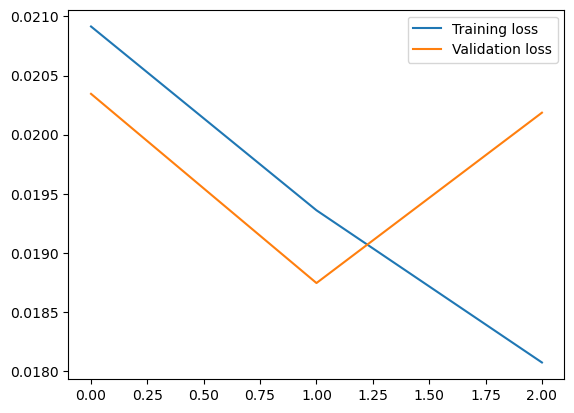

In [14]:
train_losses, valid_losses = train(
    model, criterion, optimizer, train_gen, valid_gen, n_epochs, device=device
)

plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()
plt.show()

## Evaluation (1 point)

* **\[1 point\]** Compute the accuracy for all 3 splits.

In [15]:
def accuracy(
        model: nn.Module,
        data_gen: Generator[Tuple[torch.Tensor, torch.Tensor], None, None],
        device: str,
) -> float:
    """
    Compute the accuracy of a model.
    Args:
        model: a PyTorch Module.
        data_gen: a generator returning batches.
        device: the device to run the computation on.
    Returns:
        The accuracy of the model on the data from the generator.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in data_gen():
            X, y = X.to(device), y.to(device)
            hidden = model.init_hidden(len(X)).to(device)

            output = None
            for i in range(X.size(1)):
                output, hidden = model(X[:, i], hidden)
                output = output.to(device)
                hidden = hidden.to(device)

            predicted = torch.round(torch.sigmoid(output)).squeeze()
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct / total

In [16]:
# Compute the accuracy for all 3 splits.

train_accuracy = accuracy(model, train_gen, device=device)
valid_accuracy = accuracy(model, valid_gen, device=device)
test_accuracy = accuracy(model, test_gen, device=device)

print(f'Accuracy of the training set: {train_accuracy}')
print(f'Accuracy of the validation set: {valid_accuracy}')
print(f'Accuracy of the test set: {test_accuracy}')

Accuracy of the training set: 0.6486
Accuracy of the validation set: 0.634
Accuracy of the test set: 0.6342


On remarque les accuracies correspondent à un réseau qui n'apprend rien.